In [84]:
import numpy as np
import  matplotlib.pyplot as plt
import scipy.special as sp

In [85]:
def source(no_of_users, no_of_bits):  # Function to generate a random bit stream
    # Generate a random binary matrix of shape (no_of_users, no_of_bits)
    # Each element is either 0 or 1
    return np.random.randint(0, 2, (no_of_users, no_of_bits))

no_of_users = 2  # Number of users
no_of_bits = 8000  # Number of bits per user

# Generate the message bits for the specified number of users and bits
msg_bits1 = source(no_of_users, no_of_bits)        

# Print the generated message bits
print("msg\n", msg_bits1)
# Print the length of the message bits array (which corresponds to the number of users)
print(len(msg_bits1))


msg
 [[1 0 1 ... 0 1 0]
 [1 1 0 ... 1 1 1]]
2


In [86]:
def mod(bits):
    # Mapping dictionary to convert pairs of bits to QPSK symbols
    mapping = {                     
        (0, 0): 1 + 1j,  # Maps (0, 0) to the complex symbol 1 + j
        (0, 1): -1 + 1j, # Maps (0, 1) to the complex symbol -1 + j
        (1, 0): 1 - 1j,  # Maps (1, 0) to the complex symbol 1 - j
        (1, 1): -1 - 1j  # Maps (1, 1) to the complex symbol -1 - j
    }
    
    # Initialize an empty array to store the modulated symbols
    symbols = np.array([])
    
    # Iterate over each user
    for i in range(0, len(bits), 1):
        # Iterate over each bit pair in the bit stream for the user
        for j in range(0, len(bits[0]), 2):
            bit_pair = (bits[i][j], bits[i][j+1])  # Select a pair of bits
            # Map the bit pair to the corresponding QPSK symbol and append to symbols array
            symbols = np.append(symbols, mapping[bit_pair])
        #print("mod",modulated_bits)  # This line is commented out; it would print each user's symbols

    # Return the array of modulated symbols
    return symbols

# Modulate the message bits for all users and reshape the output to match the number of users
symbols = mod(msg_bits1).reshape(no_of_users, int(no_of_bits/2))

# Print the modulated symbols
print(symbols)


[[ 1.-1.j -1.-1.j -1.-1.j ...  1.+1.j  1.+1.j  1.-1.j]
 [-1.-1.j -1.+1.j  1.-1.j ...  1.-1.j -1.-1.j -1.-1.j]]


In [87]:
import numpy as np  # Ensure numpy is imported for array operations

def awgn(symbols, snr_db):
    # Sum the columns of the symbols array to combine signals from different users
    combined_symbols = np.sum(symbols, axis=0)  # This corresponds to the expression y = ∑x_i + n
    # print(combined_symbols)
    
    # Calculate the average power of the combined signal
    signal_power = np.mean(np.abs(combined_symbols)**2)
    # print("signal power", signal_power)

    # Convert the SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10.0)
    # print(snr_linear)
    
    # Calculate the noise variance based on the signal power and SNR
    noise_variance = signal_power / (2 * snr_linear)
    # print("noise_var", noise_variance)

    # Generate complex Gaussian noise with the calculated variance
    noise = np.sqrt(noise_variance) * (np.random.randn(len(combined_symbols)) + 1j * np.random.randn(len(combined_symbols)))
    # print(noise)

    # Add the noise to the combined signal and return the result
    return combined_symbols + noise

# Define the SNR in dB (array with one value in this case)
snr_db = np.arange(0, 1, 1)

# Pass the modulated symbols through the AWGN channel
received_signal = awgn(symbols, snr_db)

# Print the received signal after adding noise
print(received_signal)


[ 1.78702717+1.08854736j -0.95828254+1.36693947j -2.40280522-3.85800432j
 ...  2.0830801 +0.99067397j -0.3257739 -1.36193812j
  0.44988691-3.84650352j]


In [88]:
def demod(received_signal):
    # Define the possible symbols for decoding
    # These symbols represent the expected values after summing the transmitted signals and adding noise
    symbols = [
        2 + 2j,  # Represents a possible decoded symbol
        2j,
        0,
        2,
        -2 + 2j,
        -2,
        -2 - 2j,
        -2j,
        2 - 2j
    ]  # The (∑x_i + noise) symbols will be decoded into these possible symbols

    # Demodulation
    demodulated_symbols = []
    for i in received_signal:
        # Find the closest symbol to the received signal based on minimum distance
        closest_symbol = min(symbols, key=lambda s: np.abs(i - s))  # Decoding summed symbols using minimum distance
        demodulated_symbols.append(closest_symbol)

    # Return the array of demodulated symbols
    return np.array(demodulated_symbols)

# Perform demodulation on the received signal
demod_symbols = demod(received_signal)

# Print the demodulated symbols
print(demod_symbols)


[ 2.+2.j  0.+2.j -2.-2.j ...  2.+0.j -0.-2.j -0.-2.j]


In [89]:
def calculate_ber(msg, rec, no_of_users, no_of_bits):
    # Modulate the original message bits to obtain the transmitted symbols
    sym1 = mod(msg)
    
    # Sum the transmitted symbols across all users to simulate the combined received signal without noise
    combined_symbols = np.sum(symbols, axis=0)  # This is used to compare with the decoded sum symbols
    
    # Print statements for debugging (currently commented out)
    # print(msg)
    # msg_sum = np.sum(msg, axis=0)
    # print("\n", msg_sum)
    # print("\n", rec)

    # Calculate the Bit Error Rate (BER) by comparing the combined transmitted symbols with the received symbols
    ber = np.mean(combined_symbols != rec)  # BER is calculated by averaging the number of symbol errors
    
    return ber

# Calculate the Bit Error Rate (BER) for the given message and received symbols
BER = calculate_ber(msg_bits1, demod_symbols, no_of_users, no_of_bits)

# Print the calculated BER
print(BER)


0.604


In [90]:
def simulate(snr_db_range, msg_bits, no_of_users, no_of_bits):
    ber = []  # Initialize an empty list to store the Bit Error Rate (BER) for each SNR value
    # print("msg\n", msg_bits)

    # Iterate over the range of SNR values provided
    for snr_db in snr_db_range:
        # print("snr=", snr_db)
        
        # Modulate the message bits to QPSK symbols for each user
        transmitted_symbols = mod(msg_bits).reshape(no_of_users, int(no_of_bits / 2))  # Modulation: bit stream --> symbols
        # print("TX\n", transmitted_symbols)
        
        # Pass the transmitted symbols through the AWGN channel
        received_symbols = awgn(transmitted_symbols, snr_db)  # Channel output = transmitted symbols + noise
        
        # Demodulate the received noisy symbols to recover the transmitted symbols
        demodulated_symbols = demod(received_symbols)  # Demodulation: noisy_symbols --> decoded symbols
        # print("demod\n", demodulated_symbols)
    
        # Calculate the Bit Error Rate (BER) for the current SNR value
        ber.append(calculate_ber(msg_bits, demodulated_symbols, no_of_users, no_of_bits))
        # print(ber)
        # print("\n\n")

    return ber  # Return the list of BER values for the given range of SNR values

# Define the range of SNR values (in dB) over which to simulate
snr_db_range = np.arange(0, 15, 1)  # Input for SNR range to plot

# Run the simulation over the specified SNR range
ser_qpsk_sum = simulate(snr_db_range, msg_bits1, no_of_users, no_of_bits)

# Print the calculated BER values for the SNR range
print(ser_qpsk_sum)


[0.5955, 0.5215, 0.48725, 0.4235, 0.36225, 0.27675, 0.2195, 0.17275, 0.108, 0.05775, 0.037, 0.02, 0.00825, 0.00225, 0.0]


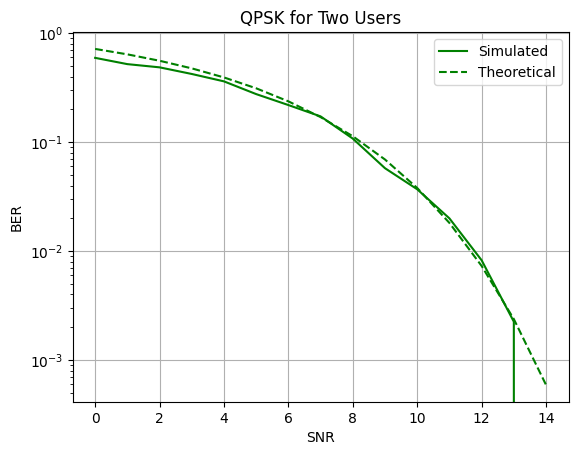

In [91]:
# Convert SNR from dB to linear scale
snr_lin = 10**(snr_db_range / 10)  # SNR (linear scale) = 10^(SNR (dB)/10)

# Theoretical Symbol Error Rate (SER) for QPSK with two users
ser_qpsk_sum_theory = 1.5 * sp.erfc(np.sqrt(snr_lin / 4))  # Theoretical formula for QPSK SER with two users

# Plot the simulated SER (Bit Error Rate) on a semi-logarithmic scale
plt.semilogy(snr_db_range, ser_qpsk_sum, linestyle='-', color="g", label='Simulated')
# Plot the theoretical SER on the same plot for comparison
plt.semilogy(snr_db_range, ser_qpsk_sum_theory, linestyle='--', color='g', label='Theoretical')


plt.xlabel("SNR")
plt.ylabel("BER")
plt.title("QPSK for Two Users")
plt.grid(True)
plt.legend()
plt.show()
